In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

/home/anishpawar/miniconda3/envs/carla1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Dataloader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

train_og = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train, val = torch.utils.data.random_split(train_og, [len(train_og) - int(0.1 * len(train_og)), int(0.1 * len(train_og))])


trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)



test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(trainloader)

352

## Pre-Proc

In [5]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

In [6]:
def imgEmbedd(images, n_patches):
    n, c, h, w = images.shape


    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [7]:
Patches = imgEmbedd(images,4)

## Attention

In [8]:


class SelfAttention(nn.Module):
    def __init__(self, N, D, device):
        super().__init__()

        self.N = N
        self.D = D
        
        self.fc1 = nn.Linear(D, 4*D).to(device)
        self.fc2 = nn.Linear(4*D, 6*D).to(device)
        self.fc3 = nn.Linear(6*D, D).to(device)

        self.WQ = nn.Parameter(torch.randn(D, D)).to(device)
        self.WV = nn.Parameter(torch.randn(D, D)).to(device)
        self.WK = nn.Parameter(torch.randn(D, D)).to(device)
        
        self.device = device

    def forward(self, X):
        Q = X @ self.WQ
        K = X @ self.WK
        V = X @ self.WV

        out_logits = Q @ K.transpose(1, 2)
        Y = F.softmax(out_logits / torch.sqrt(torch.tensor([self.D], device=X.device)), dim=1) @ V

        LN_Out = F.layer_norm(Y + X, normalized_shape=(self.N, self.D))

        x = F.relu(self.fc1(LN_Out))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        to_ret = x.view((-1, self.N, self.D)) + LN_Out

        to_ret_final = F.layer_norm(to_ret, normalized_shape=(self.N, self.D))

        return to_ret_final


In [9]:
SA1 = SelfAttention(N=16,D=192,device=device)
out = SA1.forward(Patches.to(device))

In [10]:
out.shape

torch.Size([128, 16, 192])

In [11]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, N=16, D=192, B=4, heads=2):
        super().__init__()
        self.N = N
        self.D = D
        self.B = B
        self.Numheads = heads

        self.attention_heads = nn.ModuleList([
            SelfAttention(N=self.N, D=self.D, device=None).to(device) for _ in range(self.Numheads)])

        self.output_projection = nn.Linear(self.Numheads * self.D, self.D)

    def forward(self, input):
        # Inferencing for 1st Head then appending the outputs of the rest of the heads to it
        self_attention_res = self.attention_heads[0](input)
        
        for i in range(1, self.Numheads):
            self_attention_res = torch.cat([self_attention_res, self.attention_heads[i](input)], dim=2)

        Y_MHA = self.output_projection(self_attention_res)

        output = F.layer_norm(Y_MHA + input, normalized_shape=(self.N, self.D))

        return output


In [12]:

multihead_attn = MultiHeadedAttention(N=16, D=192, B=batch_size, heads=2).to(device)
output = multihead_attn(Patches.to(device))


In [13]:
output.shape

torch.Size([128, 16, 192])

## ViT

In [14]:
class ViT(nn.Module):
    def __init__(self,X_Dummy,n_patches) -> None:
        super().__init__()
        # Giving 1 batch of training data for auto initialisation of the parameters
        self.X_Dummy = X_Dummy
        
        self.B, self.C, self.W, self.H = self.X_Dummy.shape

        self.n_patches = n_patches

        self.patches_temp = imgEmbedd(self.X_Dummy,n_patches)

        _, self.N,self.D  = self.patches_temp.shape



        # For class token
        self.N+=1


        self.MHA1 = MultiHeadedAttention(N=self.N, D=self.D, B=self.B, heads=6).to(device)

        self.MHA2 = MultiHeadedAttention(N=self.N, D=self.D, B=self.B, heads=6).to(device)


        self.fc1 = nn.Linear(self.D,4*self.D).to(device)
        self.fc2 = nn.Linear(4*self.D, 10).to(device)
        
        self.class_token = torch.rand((1, self.D),requires_grad=True).to(device)


    def forward(self,X):

        self.X = X

        self.B, self.C, self.W, self.H = self.X.shape
        

        self.patches = imgEmbedd(X,self.n_patches).to(device)

        _, self.N,self.D  = self.patches.shape

        # Appending clas token
        self.patches = torch.cat((self.class_token.expand(self.B, 1, -1), self.patches), dim=1)

        x = self.MHA1.forward(self.patches)

        x = self.MHA2.forward(x)


        x = F.relu(self.fc1(x[:,0]))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)

        return x


        

In [15]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

In [16]:
vit1 = ViT(images,4)

In [17]:
y = vit1.forward(images)

In [18]:
y.shape

torch.Size([128, 10])

In [19]:
vit1.to(device)

ViT(
  (MHA1): MultiHeadedAttention(
    (attention_heads): ModuleList(
      (0): SelfAttention(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (fc2): Linear(in_features=768, out_features=1152, bias=True)
        (fc3): Linear(in_features=1152, out_features=192, bias=True)
      )
      (1): SelfAttention(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (fc2): Linear(in_features=768, out_features=1152, bias=True)
        (fc3): Linear(in_features=1152, out_features=192, bias=True)
      )
      (2): SelfAttention(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (fc2): Linear(in_features=768, out_features=1152, bias=True)
        (fc3): Linear(in_features=1152, out_features=192, bias=True)
      )
      (3): SelfAttention(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (fc2): Linear(in_features=768, out_features=1152, bias=True)
        (fc3): Linear(in_features=1152, out_f

## Training Lop

In [20]:
from tqdm import tqdm
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit1.parameters(), lr=1e-4)

In [22]:

total_trainingloss = []
total_valloss = []

total_training_acc = []
total_val_acc = []

for epoch in range(40):
    correct_train = 0
    total_train = 0

    train_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        try:
            inputs, labels = data
            optimizer.zero_grad()

            outputs = vit1(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()


            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted.to(device) == labels.to(device)).sum().item()
        except Exception as e:
            print("I got an error")
            print(f'Error is {e}')
            pass


    print(f'Epoch: {epoch+1}')
    print(f'Train Loss is: {train_loss:.2f}')
    total_trainingloss.append(train_loss)
    print(f'Train Accuracy is: {(100*correct_train/total_train):.2f} %')

    total_training_acc.append(correct_train/total_train)

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            try:
                inputs, labels = data
                outputs = vit1(inputs.to(device))
                Valloss = criterion(outputs, labels.to(device))
                
                val_loss += Valloss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted.to(device) == labels.to(device)).sum().item()
            except:
                print("I got an error")
                pass
    
    print(f'Val Loss is: {val_loss:.2f}')
    total_valloss.append(val_loss)
    print(f'Val Accuracy is: {(100*correct_val/total_val):.2f} %')
    total_val_acc.append(correct_val/total_val)
    print('----------------------------------------------------')
 

def MHA(input,N=16,D=192,B=4,heads = 2):

    SA = SelfAttention(N=N,D=D,B = B)
    # print(input.shape)
    selfAttentionRes=SA.forward(input.to(device))
    
    
    for i in range(1,heads):
        SA = SelfAttention(N=N,D=D,B = B)
        selfAttentionRes = torch.cat([selfAttentionRes,SA.forward(input.to(device))], dim=2)
    

    Wo = torch.rand((heads*D,D)).to(device)
    Y_MHA = selfAttentionRes @ Wo

    return Y_MHA + input.to(device)



352it [00:22, 15.59it/s]

Epoch: 1
Train Loss is: 661.92
Train Accuracy is: 30.89 %


Val Loss is: 72.75
Val Accuracy is: 33.66 %
----------------------------------------------------


352it [00:22, 15.68it/s]

Epoch: 2
Train Loss is: 623.84
Train Accuracy is: 35.24 %


Val Loss is: 71.13
Val Accuracy is: 35.26 %
----------------------------------------------------


352it [00:22, 15.69it/s]

Epoch: 3
Train Loss is: 608.74
Train Accuracy is: 36.85 %


Val Loss is: 69.02
Val Accuracy is: 37.08 %
----------------------------------------------------


352it [00:22, 15.66it/s]

Epoch: 4
Train Loss is: 597.40
Train Accuracy is: 38.16 %


Val Loss is: 70.35
Val Accuracy is: 36.04 %
----------------------------------------------------


352it [00:22, 15.61it/s]

Epoch: 5
Train Loss is: 587.01
Train Accuracy is: 39.40 %


Val Loss is: 68.03
Val Accuracy is: 37.70 %
----------------------------------------------------


352it [00:22, 15.67it/s]

Epoch: 6
Train Loss is: 576.93
Train Accuracy is: 40.29 %


Val Loss is: 67.85
Val Accuracy is: 37.82 %
----------------------------------------------------


352it [00:22, 15.57it/s]

Epoch: 7
Train Loss is: 569.08
Train Accuracy is: 41.25 %


Val Loss is: 66.80
Val Accuracy is: 38.88 %
----------------------------------------------------


352it [00:22, 15.49it/s]

Epoch: 8
Train Loss is: 563.55
Train Accuracy is: 42.01 %


Val Loss is: 65.74
Val Accuracy is: 39.64 %
----------------------------------------------------


352it [00:22, 15.69it/s]

Epoch: 9
Train Loss is: 558.97
Train Accuracy is: 42.42 %


Val Loss is: 65.63
Val Accuracy is: 39.60 %
----------------------------------------------------


352it [00:22, 15.66it/s]

Epoch: 10
Train Loss is: 554.79
Train Accuracy is: 42.72 %


Val Loss is: 66.69
Val Accuracy is: 40.18 %
----------------------------------------------------


352it [00:22, 15.67it/s]

Epoch: 11
Train Loss is: 549.94
Train Accuracy is: 43.55 %


Val Loss is: 65.58
Val Accuracy is: 40.14 %
----------------------------------------------------


352it [00:22, 15.67it/s]

Epoch: 12
Train Loss is: 544.30
Train Accuracy is: 43.95 %


Val Loss is: 65.59
Val Accuracy is: 40.24 %
----------------------------------------------------


352it [00:22, 15.69it/s]

Epoch: 13
Train Loss is: 538.43
Train Accuracy is: 44.55 %


Val Loss is: 65.63
Val Accuracy is: 39.72 %
----------------------------------------------------


352it [00:22, 15.61it/s]

Epoch: 14
Train Loss is: 536.11
Train Accuracy is: 44.74 %


Val Loss is: 65.92
Val Accuracy is: 40.36 %
----------------------------------------------------


352it [00:22, 15.65it/s]

Epoch: 15
Train Loss is: 530.45
Train Accuracy is: 45.33 %


Val Loss is: 64.06
Val Accuracy is: 42.22 %
----------------------------------------------------


352it [00:22, 15.46it/s]

Epoch: 16
Train Loss is: 531.21
Train Accuracy is: 45.15 %


Val Loss is: 64.88
Val Accuracy is: 41.80 %
----------------------------------------------------


352it [00:22, 15.56it/s]

Epoch: 17
Train Loss is: 519.07
Train Accuracy is: 46.44 %


Val Loss is: 64.05
Val Accuracy is: 42.68 %
----------------------------------------------------


352it [00:22, 15.38it/s]

Epoch: 18
Train Loss is: 510.11
Train Accuracy is: 47.36 %


Val Loss is: 63.26
Val Accuracy is: 42.28 %
----------------------------------------------------


352it [00:22, 15.77it/s]

Epoch: 19
Train Loss is: 501.79
Train Accuracy is: 48.50 %


Val Loss is: 62.72
Val Accuracy is: 43.14 %
----------------------------------------------------


352it [00:22, 15.74it/s]

Epoch: 20
Train Loss is: 501.83
Train Accuracy is: 48.32 %


Val Loss is: 63.32
Val Accuracy is: 43.52 %
----------------------------------------------------


352it [00:22, 15.59it/s]

Epoch: 21
Train Loss is: 490.03
Train Accuracy is: 49.66 %


Val Loss is: 63.23
Val Accuracy is: 44.18 %
----------------------------------------------------


352it [00:22, 15.54it/s]

Epoch: 22
Train Loss is: 489.07
Train Accuracy is: 49.65 %


Val Loss is: 64.40
Val Accuracy is: 42.80 %
----------------------------------------------------


352it [00:22, 15.50it/s]

Epoch: 23
Train Loss is: 477.86
Train Accuracy is: 50.84 %


Val Loss is: 62.78
Val Accuracy is: 44.16 %
----------------------------------------------------


352it [00:22, 15.61it/s]

Epoch: 24
Train Loss is: 474.64
Train Accuracy is: 51.24 %


Val Loss is: 61.67
Val Accuracy is: 44.82 %
----------------------------------------------------


352it [00:22, 15.67it/s]

Epoch: 25
Train Loss is: 472.18
Train Accuracy is: 51.46 %


Val Loss is: 62.36
Val Accuracy is: 44.92 %
----------------------------------------------------


352it [00:22, 15.64it/s]

Epoch: 26
Train Loss is: 460.68
Train Accuracy is: 52.50 %


Val Loss is: 63.78
Val Accuracy is: 44.22 %
----------------------------------------------------


352it [00:22, 15.84it/s]

Epoch: 27
Train Loss is: 459.43
Train Accuracy is: 52.67 %


Val Loss is: 62.94
Val Accuracy is: 44.34 %
----------------------------------------------------


352it [00:22, 15.74it/s]

Epoch: 28
Train Loss is: 455.61
Train Accuracy is: 53.32 %


Val Loss is: 62.49
Val Accuracy is: 44.60 %
----------------------------------------------------


352it [00:22, 15.57it/s]

Epoch: 29
Train Loss is: 447.84
Train Accuracy is: 53.99 %


Val Loss is: 62.48
Val Accuracy is: 45.18 %
----------------------------------------------------


352it [00:22, 15.64it/s]

Epoch: 30
Train Loss is: 446.61
Train Accuracy is: 54.25 %


Val Loss is: 63.06
Val Accuracy is: 44.98 %
----------------------------------------------------


352it [00:22, 15.62it/s]

Epoch: 31
Train Loss is: 438.09
Train Accuracy is: 55.00 %


Val Loss is: 62.53
Val Accuracy is: 44.58 %
----------------------------------------------------


352it [00:22, 15.74it/s]

Epoch: 32
Train Loss is: 430.34
Train Accuracy is: 55.72 %


Val Loss is: 62.38
Val Accuracy is: 44.50 %
----------------------------------------------------


352it [00:22, 15.77it/s]

Epoch: 33
Train Loss is: 420.86
Train Accuracy is: 56.76 %


Val Loss is: 64.02
Val Accuracy is: 45.06 %
----------------------------------------------------


352it [00:22, 15.76it/s]

Epoch: 34
Train Loss is: 412.43
Train Accuracy is: 57.66 %


Val Loss is: 63.84
Val Accuracy is: 45.18 %
----------------------------------------------------


352it [00:22, 15.83it/s]

Epoch: 35
Train Loss is: 402.71
Train Accuracy is: 58.51 %


Val Loss is: 62.36
Val Accuracy is: 46.50 %
----------------------------------------------------


352it [00:22, 15.89it/s]

Epoch: 36
Train Loss is: 410.33
Train Accuracy is: 57.88 %


Val Loss is: 62.89
Val Accuracy is: 45.52 %
----------------------------------------------------


352it [00:22, 15.63it/s]

Epoch: 37
Train Loss is: 398.13
Train Accuracy is: 59.08 %


Val Loss is: 61.95
Val Accuracy is: 46.00 %
----------------------------------------------------


352it [00:22, 15.83it/s]

Epoch: 38
Train Loss is: 388.90
Train Accuracy is: 59.95 %


Val Loss is: 62.83
Val Accuracy is: 46.86 %
----------------------------------------------------


352it [00:22, 15.72it/s]

Epoch: 39
Train Loss is: 384.59
Train Accuracy is: 60.30 %


Val Loss is: 64.22
Val Accuracy is: 45.14 %
----------------------------------------------------


352it [00:22, 15.60it/s]

Epoch: 40
Train Loss is: 371.95
Train Accuracy is: 61.85 %


Val Loss is: 64.70
Val Accuracy is: 45.66 %
----------------------------------------------------


In [43]:
def lossPlotter(training_loss,val_loss,type="Loss"):
    x = range(len(training_loss))

    y1 = training_loss
    y2 = val_loss

    

    fig, ax1 = plt.subplots()


    
    plt.plot(x,y1, label=f'Training {type}')
    plt.plot(x,y2, label=f'Validation {type}')
    
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    
    plt.title(f'{type} Plot')
    plt.legend()
    plt.show()


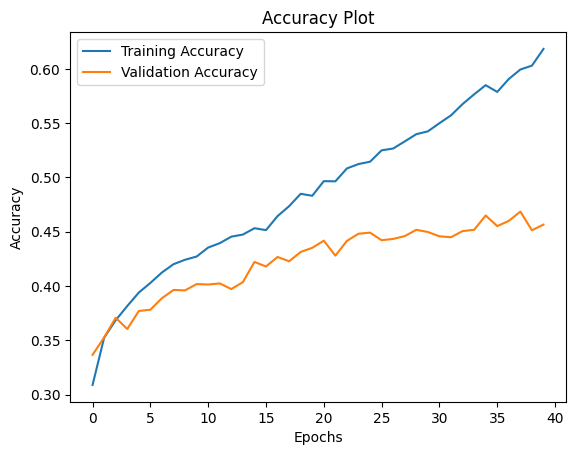

In [46]:
lossPlotter(training_loss=total_training_acc,val_loss=total_val_acc,type="Accuracy")

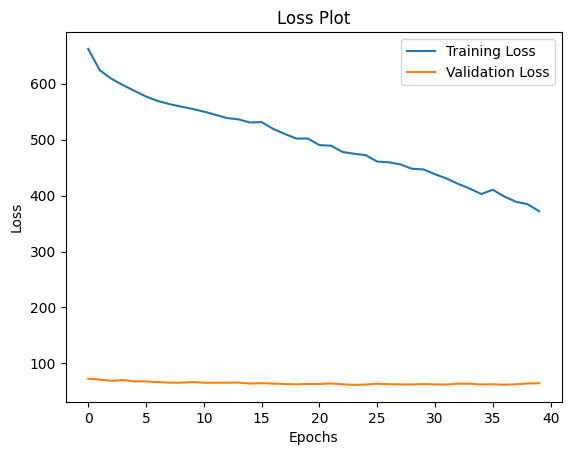

In [47]:
lossPlotter(training_loss=total_trainingloss,val_loss=total_valloss,type="Loss")

In [48]:
from  datetime import datetime

In [49]:
current_datetime = datetime.now()
current_datetime.strftime("%Y-%m-%d %H:%M:%S")

PATH = f'./cifar_ViT_{total_training_acc[-1]:.2f}__{current_datetime}.pth'
torch.save(vit1.state_dict(), PATH)

In [21]:
PATH = "cifar_ViT_0.62__2024-03-29 18:06:31.688569.pth"

In [22]:
vit1 = ViT(images,4)
vit1.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:

test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = vit1(inputs.to(device))
        testloss = criterion(outputs, labels.to(device))
        
        test_loss += testloss.item()

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted.to(device) == labels.to(device)).sum().item()

    print(f'Test Loss is: {testloss:.2f}')
    print(f'Test Accuracy is: {(100*correct_test/total_test):.2f} %')
    print('----------------------------------------------------')

Test Loss is: 1.76
Test Accuracy is: 39.44 %
----------------------------------------------------


Metrics of Conv+SA and ViT:

- Conv+SA:
    - Train:83.86 %

    - Test: 55.33 %

    - Val: 57.88 %

- ViT:
    - Train: 61.85 %

    - Test: 39.44 %

    - Val: 45.66 %


Upon comparison of the two models, CNN+ Self Attention Model is performing better